In [1]:
!pip install scikit-survival
import sksurv
print(sksurv.__version__)

!pip install xgboost
import xgboost as xgb
print(xgb.__version__)



     |████████████████████████████████| 2.3 MB 28.5 MB/s eta 0:00:01     |█▌                              | 112 kB 28.5 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 309 kB 122.3 MB/s eta 0:00:01
     |████████████████████████████████| 12.7 MB 247 kB/s eta 0:00:011
     |████████████████████████████████| 378 kB 116.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.7 MB 122.4 MB/s eta 0:00:01
     |████████████████████████████████| 232 kB 125.5 MB/s eta 0:00:01
     |████████████████████████████████| 6.8 MB 122.9 MB/s eta 0:00:01
     |████████████████████████████████| 10.7 MB 90.3 MB/s eta 0:00:01
     |████████████████████████████████| 142 kB 121.5 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.1 MB 115.

In [30]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
import pickle
import warnings

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from random import choices
from tqdm.notebook import tqdm

from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
#from sklearn.preprocessing import StandardScaler
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
)

pd.set_option('display.max_columns', None) # Display all columns in a pandas dataframe

FRACTURES = ["vertebral_fracture", "hip_fracture", "any_fracture"]  # not enough wrist fracture cases

# Define times at which to measure AUC (every year)
TIMES = np.arange(12, 95, 12)
TIME_TO_EVALUATE = 24

In [2]:
# Define features to use for validation on UK Biobank
FEATURES = [
    "age", "bmi", "hrt", "decrease_in_height", "ankylosing_spondylitis", "copd",
    "hyperpara", "type_1_diabetes", "rheumatoid_arthritis", "number_of_falls",
    "early_menopause", "nicotin", "alcohol", "gastrointestinal_disease",
    "tscore_ls", "tscore_neck", "tscore_totalHip", "tbs_ls", "min_tscore",
    "imminent_fracture", "previous_fracture"
]

In [3]:
# Load dataset
data_ukb = pd.read_csv("/mnt/project/data/final/merged_table.csv")
data_ukb.rename(columns={
    "vertebral_fx": "vertebral_fracture",
    "hip_fx": "hip_fracture",
    "wrist_fx": "wrist_fracture",
    "any_fx": "any_fracture",
    "imminent_fx": "imminent_fracture",
    "previous_fx": "previous_fracture",
    "decrease in height": "decrease_in_height"
}, inplace=True)
data_ukb["min_tscore"] = data_ukb[["tscore_ls", "tscore_neck", "tscore_totalHip"]].min(axis=1)
data_ukb = data_ukb.dropna()
data_ukb

,patientId,date,vertebral_fracture,hip_fracture,wrist_fracture,any_fracture,vertebral_right_censored,hip_right_censored,wrist_right_censored,any_right_censored,imminent_fracture,previous_fracture,age,hrt,height,weight,bmi,decrease_in_height,osteoporotic_fracture_parents,corticosteroids,aromatase_inhibitors,antiepileptic_drugs,ankylosing_spondylitis,copd,hyperpara,type_1_diabetes,rheumatoid_arthritis,number_of_falls,early_menopause,nicotin,alcohol,gastrointestinal_disease,tbs_ls,tscore_ls,tscore_neck,tscore_totalHip,bisphosphonates_prior,bisphosphonates_current,bisphosphonates_new,serm_prior,serm_current,serm_new,teriparatide_prior,teriparatide_current,teriparatide_new,hrt_prior,hrt_current,hrt_new,osteoporosis,min_tscore
0,1001554,2018-03-22,6.8667,6.8667,6.8667,6.8667,True,True,True,True,0.0,0.0,67,False,153.0,56.7,24.2215,False,False,False,False,False,True,False,False,False,False,No falls,False,False,False,False,1.017,-2.730180,-0.617614,-0.995070,False,False,False,False,False,False,False,False,False,False,False,False,True,-2.730180
3,1005492,2016-06-13,62.3257,62.3257,62.3257,62.3257,True,True,True,True,0.0,0.0,58,False,164.0,100.1,36.3260,False,False,False,False,False,False,False,False,False,False,No falls,False,False,False,False,1.199,2.043910,0.874155,0.755662,False,False,False,False,False,False,False,False,False,False,False,False,False,0.755662
4,1006076,2018-09-18,34.3334,34.3334,34.3334,34.3334,True,True,True,True,0.0,0.0,69,False,161.0,57.7,22.9677,False,False,False,False,False,False,False,False,False,False,No falls,False,False,False,False,1.089,-0.480305,-0.410832,-0.063631,False,False,False,False,False,False,False,False,False,False,False,False,False,-0.480305
5,1006157,2017-05-24,44.5512,44.5512,44.5512,44.5512,True,True,True,True,0.0,0.0,69,True,165.0,77.3,28.7403,False,False,False,False,False,False,False,False,False,False,No falls,False,False,False,False,1.017,-0.431716,-0.895375,-0.643109,False,False,False,False,False,False,False,False,False,True,False,False,False,-0.895375
8,1008512,2018-11-15,7.8852,7.8852,7.8852,7.8852,True,True,True,True,0.0,0.0,56,False,156.0,50.2,21.1671,False,False,False,False,False,False,False,False,False,False,More than one fall,False,False,False,False,1.042,-2.311220,-0.638753,-1.115440,False,False,False,False,False,False,False,False,False,False,False,False,False,-2.311220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8383,6016008,2017-01-26,53.4878,53.4878,53.4878,53.4878,True,True,True,True,0.0,0.0,72,True,159.0,63.2,26.3059,False,False,False,False,False,False,False,False,False,False,Only one fall,False,False,False,False,0.992,-1.574190,-1.961960,-2.128020,False,False,False,False,False,False,False,False,False,True,False,False,False,-2.128020
8385,6018073,2015-04-07,61.9315,61.9315,61.9315,61.9315,True,True,True,True,0.0,0.0,72,True,159.0,52.7,21.6552,False,True,False,False,False,False,False,False,False,False,No falls,True,False,False,False,1.132,-3.188170,-2.896560,-2.954540,False,False,False,False,False,False,False,False,False,True,False,False,True,-3.188170
8387,6020460,2015-12-02,20.6657,20.6657,20.6657,20.6657,True,True,True,True,0.0,0.0,64,True,171.0,69.8,24.7307,False,False,False,False,False,False,False,False,False,False,No falls,False,False,False,False,1.170,-1.600300,-1.628120,-1.953780,False,False,False,False,False,False,False,False,False,False,False,False,False,-1.953780
8389,6023119,2015-10-02,45.6026,45.6026,45.6026,45.6026,True,True,True,True,0.0,0.0,57,True,161.0,62.7,23.8912,False,False,False,False,False,False,False,False,False,False,No falls,False,False,False,False,1.294,1.472440,0.914185,1.294470,False,False,False,False,False,False,False,False,False,False,True,False,False,0.914185


In [4]:
def produce_stats(df, c_index_scores, auc_scores, t=24):
    # Extract fx type
    fx_type = list(c_index_scores["train"].keys())[0].split("_")[0]
    
    for tv in ["train", "valid"]:
        harrel_global = round(np.mean(c_index_scores[tv][f"{fx_type}_harrel_global"]), 4)
        harrel_2y = round(np.mean(c_index_scores[tv][f"{fx_type}_harrel"]), 4)
        uno_2y = round(np.mean(c_index_scores[tv][f"{fx_type}_uno"]), 4)
        
        df.loc[(fx_type, tv), "harrel_global"] = harrel_global
        df.loc[(fx_type, tv), "harrel_2y"] = harrel_2y
        df.loc[(fx_type, tv), "uno_2y"] = uno_2y
        
        print("-"*13 + f" {tv} " + "-"*13)
        print("Harrels C-Index (Global):", harrel_global)
        print(f"Harrels C-Index (at t={t}):", harrel_2y)
        print("Unos C-Index:", uno_2y)
    
    auc_2y = round(np.mean(auc_scores[fx_type], axis=0)[t//12 - 1], 4)
    auc_mean = round(np.mean(auc_scores[f"{fx_type}_mean"]), 4)
    df.loc[(fx_type, "valid"), "auc_2y"] = auc_2y
    df.loc[(fx_type, "valid"), "auc_mean"] = auc_mean
    print(f"AUC at {t//12}y:", auc_2y)
    print("Mean AUC:", auc_mean)
    
    return df


def prepare_labels(df, model_type):
    if model_type == "aft":
        # Create lower and upper bounds for AFT
        for idx in df.index:
            for fx_type in ["vertebral", "hip", "wrist", "any"]:
                time_to_event = df.loc[idx, fx_type + "_fracture"]
                if df.loc[idx,fx_type + "_right_censored"] == 0:
                    df.loc[idx, fx_type + "_lower_bound"] = time_to_event
                    df.loc[idx, fx_type + "_upper_bound"] = time_to_event
                else:
                    df.loc[idx, fx_type + "_lower_bound"] = time_to_event
                    df.loc[idx, fx_type + "_upper_bound"] = np.inf
        return df.loc[:, "vertebral_lower_bound":"any_upper_bound"]

    elif model_type == "cox":
        # Make censored values negative
        for idx in df.index:
            for fx_type in ["vertebral", "hip", "wrist", "any"]:
                censored = df.loc[idx, fx_type + "_right_censored"]
                tte = df.loc[idx, fx_type + "_fracture"]
                if censored:
                    df.loc[idx, fx_type + "_label"] = - tte
                else:
                    df.loc[idx, fx_type + "_label"] = tte
        return df.loc[:, "vertebral_label":"any_label"]
    else:
        # Select and transform y's
        fractures = {}
        for fx_type in ["vertebral", "hip", "wrist", "any"]:
            y = df.loc[:, [f"{fx_type}_right_censored", f"{fx_type}_fracture"]]
            y[f"{fx_type}_right_censored"] = y[f"{fx_type}_right_censored"].apply(lambda x: not x)
            y = [(e1, e2) for e1, e2 in y.to_numpy()]
            y = np.array(y, dtype=[('Event_observed', '?'), ('Survival_in_months', '<f8')])
            fractures[f"{fx_type}_label"] = y
        return fractures


def prepare_data(data, fx_type, scaler=None, feature_list=[], model_type=None, standardize=False):
    data = data.dropna()
    
    # Prepare labels for xgboost
    labels = prepare_labels(data.loc[:,"vertebral_fracture":"any_right_censored"].copy(), model_type=model_type)
    
    features_to_drop = ["patientId", "date", "height", "weight", "osteoporosis"] 
    
    # Feature Engineering
    data["min_tscore"] = data[["tscore_ls", "tscore_totalHip", "tscore_neck"]].min(axis=1)
    data["number_of_falls"] = data["number_of_falls"].apply(lambda x: 2 if x == "More than one fall" else (1 if x == "Only one fall" else 0))
    
    fracture_columns = ["vertebral_fracture", "hip_fracture", "wrist_fracture", "any_fracture", "vertebral_right_censored", "hip_right_censored", "wrist_right_censored", "any_right_censored"]
    
    if standardize:
        # Standardize values
        continuous_variables = [
            "bmi", "age", "tscore_ls", "tscore_neck", "tscore_totalHip", 
            "min_tscore", "tbs_ls", "imminent_fracture", "previous_fracture"
        ]
        if scaler is None:
            scaler = StandardScaler()
            scaler.fit(data[continuous_variables])
        data[continuous_variables] = scaler.transform(data[continuous_variables])
    
    # Feature Selection
    if len(feature_list) > 0:
        X = data[feature_list].copy()
    else:
        X = data.drop(features_to_drop + fracture_columns, axis=1)
    
    # Define return dictionary
    prepared_data = {
        "X": X.astype(np.float64),
        "scaler": scaler
    }
    if model_type == "aft":
        prepared_data["y_lower_bound"] = labels[f'{fx_type}_lower_bound']
        prepared_data["y_upper_bound"] = labels[f'{fx_type}_upper_bound']
    
    else:
        prepared_data["y"] = labels[f'{fx_type}_label']
    
    return prepared_data


def censor_after(y, t=24):
    y_copy = y.copy()
    larger_than_t = (y_copy["Survival_in_months"] > t)
    y_copy["Event_observed"][larger_than_t] = 0
    return y_copy


def reshape_y_from_dmatrix(dmatrix, model_type, censored_after=0):
    """
    Reshape y from DMarix into a numpy array of tuples.
    The tuples are of the form (event_observed, survival_in_months)
    """
    if model_type == "aft":
        lower_bounds = dmatrix.get_float_info("label_lower_bound")
        upper_bounds = dmatrix.get_float_info("label_upper_bound")
        y = pd.DataFrame({
            "Event_observed": np.where(upper_bounds < np.inf, 1, 0),
            "Survival_in_months": lower_bounds
        })
        
    elif model_type == "cox":
        labels = dmatrix.get_label()
        y = pd.DataFrame({
            "Event_observed": pd.Series(labels).apply(lambda x: 1 if x > 0 else 0),
            "Survival_in_months": np.abs(labels)
        })
    
    # Create structured array    
    y = [(e1, e2) for e1, e2 in y.to_numpy()]
    y = np.array(y, dtype=[("Event_observed", "?"), ("Survival_in_months", "<f8")])
    
    if censored_after > 0:
        return censor_after(y, t=censored_after)
    return y


def create_dmatrix(prep_data, model_type):
    X = prep_data["X"]
    dmatrix = xgb.DMatrix(X.values, feature_names=X.columns.tolist())
    if model_type == "aft":
        dmatrix.set_float_info('label_lower_bound', prep_data["y_lower_bound"])
        dmatrix.set_float_info('label_upper_bound', prep_data["y_upper_bound"])
    elif model_type == "cox":
        dmatrix.set_label(prep_data["y"])
    return dmatrix
        

In [5]:
def provide_stratified_bootstap_sample_indices(bs_sample, fx_type):
    fx_type = fx_type + "_right_censored"
    strata = bs_sample.loc[:, fx_type].value_counts()
    bs_index_list_stratified = []

    for idx_stratum_var, n_stratum_var in strata.iteritems():

        data_index_stratum = list(bs_sample[bs_sample[fx_type] == idx_stratum_var].index)
        bs_index_list_stratified.extend(choices(data_index_stratum , k = len(data_index_stratum )))

    return bs_index_list_stratified

In [26]:
def get_confidence_interval(arr, alpha, decimals=4, ax=None):
    lower = np.percentile(arr, ((1.0-alpha)/2.0) * 100, axis=ax)
    upper = np.percentile(arr, (alpha+((1.0-alpha)/2.0)) * 100, axis=ax)
    if ax is None:
        lower = round(lower, decimals)
        upper = round(upper, decimals)
    return lower, upper

## Cox PH

vertebral



Harrel C-Index (global): 0.6723
Harrel C-Index (t=24): 0.7334
Uno C-Index: 0.7151 [0.582, 0.864]
Cum/Dyn AUC at 2 years: 0.7154
Mean cum/dyn AUC: 0.537

hip


/opt/conda/lib/python3.6/site-packages/sksurv/metrics.py:460: RuntimeWarning: invalid value encountered in true_divide
  sens = numpy.array(true_pos) / ipcw[is_case].sum()



Harrel C-Index (global): 0.6943
Harrel C-Index (t=24): 0.7252
Uno C-Index: 0.7516 [0.607, 0.901]
Cum/Dyn AUC at 2 years: 0.7507
Mean cum/dyn AUC: nan

any



Harrel C-Index (global): 0.6001
Harrel C-Index (t=24): 0.5927
Uno C-Index: 0.5962 [0.542, 0.655]
Cum/Dyn AUC at 2 years: 0.5958
Mean cum/dyn AUC: 0.5052



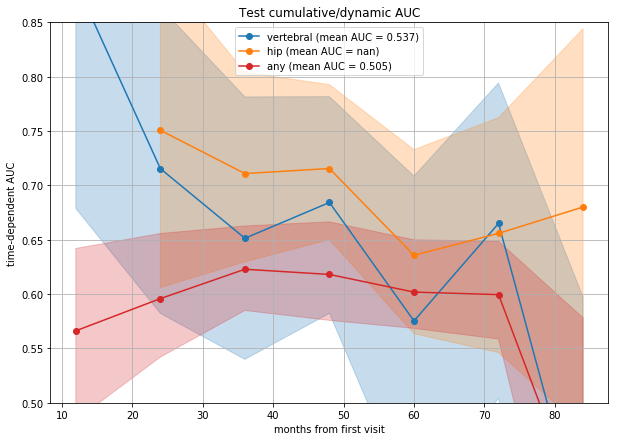

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Load pre-fit standard scaler
scaler = pickle.load(open(f"/mnt/project/models/cox/scaler2.pkl", "rb"))
for i, fx in enumerate(FRACTURES):
    fx_type = fx.split("_")[0]
    print(fx_type)
    
    # Load pre-trained model
    model = pickle.load(open(f"/mnt/project/models/cox/{fx_type}.pkl", "rb"))
    
    c_index_scores = {"harrel_global": [], "harrel_2y": [], "uno_2y": []}
    auc_scores = {"auc": [], "mean_auc": []}
    # If bootstrap, subsample test set and evaluate on 100 different bootstrap samples
    n_bootstrap = 100
    for bootsrap_idx in tqdm(range(n_bootstrap)):
        bs_sample = data_ukb.copy()
        
        bs_index_list_stratified = provide_stratified_bootstap_sample_indices(bs_sample, fx_type)
        bs_sample = bs_sample.loc[bs_index_list_stratified , :]
        #print(bs_sample.loc[:,fx_type + "_right_censored"].value_counts())
        #test_set_i = data_ukb.sample(frac=0.8, random_state=bootsrap_idx)
        test_prepped = prepare_data(bs_sample, fx_type, scaler, feature_list=FEATURES, standardize=True)
        X_test, y_test = test_prepped["X"], test_prepped["y"]
                
        # Compute cumlutaive hazard functions over time for each patient
        # They can be understood as our risk scores at a specific time
        chf_funcs = model.predict_cumulative_hazard_function(X_test)
        risk_scores = [chf(TIME_TO_EVALUATE) for chf in chf_funcs]
    
        # Censor events after time t
        y_test_censored = censor_after(y_test, TIME_TO_EVALUATE)
            
        # Compute Harrel's and Uno's C-Index
        c_index_harrel_glob = model.score(X_test, y_test)
        c_index_harrel, _, _, _, _ = concordance_index_censored(y_test_censored["Event_observed"], y_test_censored["Survival_in_months"], risk_scores)
        c_index_uno, _, _, _, _ = concordance_index_ipcw(y_test, y_test_censored, risk_scores)
        c_index_scores["harrel_global"].append(c_index_harrel_glob)
        c_index_scores["harrel_2y"].append(c_index_harrel)
        c_index_scores["uno_2y"].append(c_index_uno)
        
        # Compute and plot cululative/dynamic AUC
        auc, mean_auc = cumulative_dynamic_auc(y_test, y_test, risk_scores, TIMES)
        auc_scores["auc"].append(auc)
        auc_scores["mean_auc"].append(mean_auc)
    
    print("Harrel C-Index (global):", round(np.mean(c_index_scores["harrel_global"]), 4))
    print("Harrel C-Index (t=24):", round(np.mean(c_index_scores["harrel_2y"]), 4))
    uno_2y = round(np.mean(c_index_scores['uno_2y']), 4)
    alpha = 0.95
    # 95% confidence intervals
    lower = round(np.percentile(c_index_scores["uno_2y"], ((1.0-alpha)/2.0) * 100), 3)
    upper = round(np.percentile(c_index_scores["uno_2y"], (alpha+((1.0-alpha)/2.0)) * 100), 3)
    print(f"Uno C-Index: {uno_2y} [{lower}, {upper}]")
    print("Cum/Dyn AUC at 2 years:", round(np.mean(auc_scores["auc"], axis=0)[1], 4))
    print("Mean cum/dyn AUC:", round(np.mean(auc_scores["mean_auc"]), 4))
    
    # Compute and plot cululative/dynamic AUC
    if i == 2:
        i += 1  # plot in red color
    ax.plot(TIMES, np.mean(auc_scores["auc"], axis=0), "o-", color=f'C{i}', label="{} (mean AUC = {:.3f})".format(fx_type, np.mean(auc_scores["mean_auc"])))
    
    # 95% confidence intervals
    alpha = 0.95
    lower = np.percentile(auc_scores["auc"], ((1.0-alpha)/2.0) * 100, axis=0)
    upper = np.percentile(auc_scores["auc"], (alpha+((1.0-alpha)/2.0)) * 100, axis=0)
    ax.fill_between(TIMES, lower, upper, color=f'C{i}', alpha=0.25)
    
    ax.set_title("Test cumulative/dynamic AUC")
    ax.set_ylim(0.5, 0.85)
    ax.set_xlabel("months from first visit")
    ax.set_ylabel("time-dependent AUC")
    ax.legend(loc="upper center")
    ax.grid(True)
    
    print()

In [41]:
cox_test_results = {
    "vertebral": {"harrel_global": 0.6723, "harrel_2y": 0.7334, 'uno_2y': {'c-index': 0.7151, 'lower': 0.582, 'upper': 0.864}, 'auc': 0.7154, 'auc_mean': 0.537},
    "hip": {'harrel_global': 0.6943, 'harrel_2y': 0.7252, 'uno_2y': {'c-index': 0.7516, 'lower': 0.607, 'upper': 0.901}, 'auc': 0.7507, 'auc_mean': None},
    "any": {'harrel_global': 0.6001, 'harrel_2y': 0.5927, 'uno_2y': {'c-index': 0.5962, 'lower': 0.542, 'upper': 0.655}, 'auc': 0.5958, 'auc_mean': 0.5052}
}

In [7]:
(data_ukb[["vertebral_fracture", "hip_fracture", "any_fracture"]] >= 84).sum()

vertebral_fracture    16
hip_fracture          15
any_fracture          15
dtype: int64

In [8]:
data_ukb[["vertebral_fracture", "hip_fracture", "any_fracture", "vertebral_right_censored", "hip_right_censored", "any_right_censored"]][(data_ukb[["vertebral_fracture", "hip_fracture", "any_fracture"]] >= 84).any(axis=1)]

,vertebral_fracture,hip_fracture,any_fracture,vertebral_right_censored,hip_right_censored,any_right_censored
731,87.2626,87.2626,87.2626,True,True,True
780,84.4371,84.4371,84.4371,True,True,True
2385,84.4371,84.4371,84.4371,True,True,True
2454,87.4926,87.4926,87.4926,True,True,True
2505,85.8170,85.8170,85.8170,True,True,True
2572,85.9155,85.9155,85.9155,True,True,True
2688,85.7841,85.7841,85.7841,True,True,True
3459,84.1085,84.1085,84.1085,True,True,True
4126,85.8498,85.8498,85.8498,True,True,True
4830,87.4597,87.4597,87.4597,True,True,True


## Random Survival Forest

vertebral


/opt/conda/lib/python3.6/site-packages/sksurv/ensemble/forest.py:462: FutureWarning: predict_cumulative_hazard_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  FutureWarning)


AttributeError: 'SurvivalTree' object has no attribute 'n_features_'

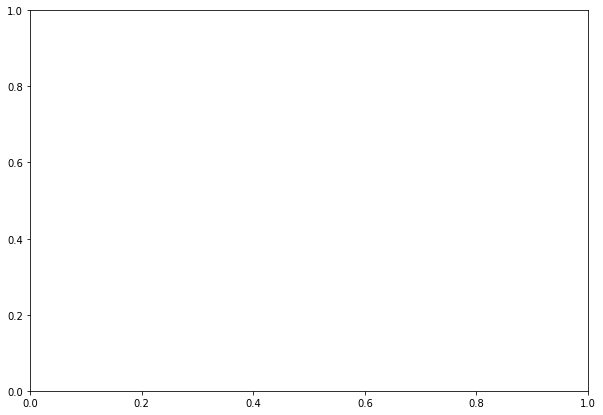

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Load pre-fit standard scaler
#scaler = pickle.load(open(f"/mnt/project/models/cox/scaler.pkl", "rb"))
for i, fx in enumerate(FRACTURES):
    fx_type = fx.split("_")[0]
    print(fx_type)
    
    # Load pre-trained model
    model = pickle.load(open(f"/mnt/project/models/rsf/{fx_type}2.json", "rb"))
    
    c_index_scores = {"harrel_global": [], "harrel_2y": [], "uno_2y": []}
    auc_scores = {"auc": [], "mean_auc": []}
    # If bootstrap, subsample test set and evaluate on 5 different folds
    n_test_sets = 5 
    for bootsrap_idx in range(n_test_sets):
        test_set_i = data_ukb.sample(frac=0.8, random_state=bootsrap_idx)
        test_prepped = prepare_data(test_set_i, fx_type, feature_list=FEATURES)
        X_test, y_test = test_prepped["X"], test_prepped["y"]
                
        # Compute cumlutaive hazard functions over time for each patient
        # They can be understood as our risk scores at a specific time
        chf_funcs = model.predict_cumulative_hazard_function(X_test)
        risk_scores = [chf(TIME_TO_EVALUATE) for chf in chf_funcs]
    
        # Censor events after time t
        y_test_censored = censor_after(y_test, TIME_TO_EVALUATE)
            
        # Compute Harrel's and Uno's C-Index
        c_index_harrel_glob = model.score(X_test, y_test)
        c_index_harrel, _, _, _, _ = concordance_index_censored(y_test_censored["Event_observed"], y_test_censored["Survival_in_months"], risk_scores)
        c_index_uno, _, _, _, _ = concordance_index_ipcw(y_test, y_test_censored, risk_scores)
        c_index_scores["harrel_global"].append(c_index_harrel_glob)
        c_index_scores["harrel_2y"].append(c_index_harrel)
        c_index_scores["uno_2y"].append(c_index_uno)
        
        # Compute and plot cululative/dynamic AUC
        auc, mean_auc = cumulative_dynamic_auc(y_test, y_test, risk_scores, TIMES)
        auc_scores["auc"].append(auc)
        auc_scores["mean_auc"].append(mean_auc)
    
    print("Harrel C-Index (global):", round(np.mean(c_index_scores["harrel_global"]), 4))
    print("Harrel C-Index (t=24):", round(np.mean(c_index_scores["harrel_2y"]), 4))
    print("Uno C-Index:", round(np.mean(c_index_scores["uno_2y"]), 4))
    print("Cum/Dyn AUC at 2 years:", round(np.mean(auc_scores["auc"], axis=0)[1], 4))
    print("Mean cum/dyn AUC:", round(np.mean(auc_scores["mean_auc"]), 4))
    
    # Compute and plot cululative/dynamic AUC
    if i == 2:
        i += 1
    ax.plot(TIMES, np.mean(auc_scores["auc"], axis=0), "o-", color=f'C{i}', label="{} (mean AUC = {:.3f})".format(fx_type, np.mean(auc_scores["mean_auc"])))
    
    # 95% confidence intervals
    alpha = 0.95
    lower = np.percentile(auc_scores["auc"], ((1.0-alpha)/2.0) * 100, axis=0)
    upper = np.percentile(auc_scores["auc"], (alpha+((1.0-alpha)/2.0)) * 100, axis=0)
    ax.fill_between(TIMES, lower, upper, color=f'C{i}', alpha=0.25)
    
    ax.set_title("Test cumulative/dynamic AUC")
    ax.set_ylim(0.5, 0.85)
    ax.set_xlabel("months from first visit")
    ax.set_ylabel("time-dependent AUC")
    ax.legend(loc="upper center")
    ax.grid(True)
    
    print()

## XGBoost AFT

In [35]:
def test_model(
    test_data, 
    t, 
    times, 
    modelname=None, 
    calibrated=False, 
    fractures=FRACTURES,
    features=[]
):
    model_type = modelname.split("_")[0]
    
    _, ax = plt.subplots(1, 1, figsize=(10, 7))
    test_scores = {}
    for i, fx in enumerate(fractures):
        fx_type = fx.split("_")[0]
        print(fx_type)
        
        # Load pre-trained xgboost model
        xgb_model = xgb.Booster()
        xgb_model.load_model(f"/mnt/project/models/xgboost_{model_type}/{fx_type}2.json")
        
        if calibrated:
            # Load pre-trained Cox-model
            raise NotImplementedError("Pretrained calibrated Cox model has not yet been uploaded to UKB.")
            #cox_model = pickle.load(...)
        
        c_index_scores = {"harrel_global": [], "harrel_2y": [], "uno_2y": []}
        auc_scores = {"auc": [], "mean_auc": []}
        
        # Bootstrap test set with 100 samples
        n_bootstrap = 100
        for bootsrap_idx in tqdm(range(n_bootstrap)):
            bs_sample = test_data.copy()
            
            # Create bootstrap sample
            bs_index_list_stratified = provide_stratified_bootstap_sample_indices(bs_sample, fx_type)
            bs_sample = bs_sample.loc[bs_index_list_stratified , :].reset_index(drop=True)
            test_data_prep = prepare_data(
                bs_sample, fx_type, model_type=model_type, feature_list=features
            )
            # Create D-Matrices used for testing
            dtest = create_dmatrix(test_data_prep, model_type)

            # Predict time-to-event on train and validation set
            test_predicted = xgb_model.predict(dtest)
        
            if calibrated:    
                # Predict cumulative hazard functions
                chf_funcs_test = cox_model.predict_cumulative_hazard_function(test_predicted.reshape(-1, 1))
                risk_scores = np.row_stack([chf(times) for chf in chf_funcs_test])
                y_pred = [chf(t) for chf in chf_funcs_test]
                
            else:
                if model_type == "aft":
                    # Limit predicted output to 100'000 (larger values can lead to computation errors)
                    max_value = 100000
                    test_predicted = np.where(test_predicted < max_value, test_predicted, max_value)
                    test_predicted = -test_predicted
                y_pred = test_predicted   
        
            # Reshape y for c-index calculation with 
            y_test = reshape_y_from_dmatrix(dtest, model_type)
            y_test_censored = reshape_y_from_dmatrix(dtest, model_type, censored_after=t)

            # Compute scores
            c_index_harrel_glob, _, _, _, _ = concordance_index_censored(y_test["Event_observed"], y_test["Survival_in_months"], y_pred)
            c_index_harrel, _, _, _, _ = concordance_index_censored(y_test_censored["Event_observed"], y_test_censored["Survival_in_months"], y_pred)
            c_index_uno, _, _, _, _ = concordance_index_ipcw(y_test, y_test_censored, y_pred)
            c_index_scores["harrel_global"].append(c_index_harrel_glob)
            c_index_scores["harrel_2y"].append(c_index_harrel)
            c_index_scores["uno_2y"].append(c_index_uno)
            
            # Compute cumulative/dynamic AUC
            auc, mean_auc = cumulative_dynamic_auc(y_test, y_test, y_pred, times)
            auc_scores["auc"].append(auc)
            auc_scores["mean_auc"].append(mean_auc)
        
        # 95% confidence intervals
        uno_lower, uno_upper = get_confidence_interval(c_index_scores["uno_2y"], alpha=0.95, decimals=3)
        test_scores[fx_type] = {
            "harrel_global": round(np.mean(c_index_scores["harrel_global"]), 4),
            "harrel_2y": round(np.mean(c_index_scores["harrel_2y"]), 4),
            "uno_2y": {
                "c-index": round(np.mean(c_index_scores['uno_2y']), 4),
                "lower": uno_lower,
                "upper": uno_upper,
            },
            "auc": round(np.mean(auc_scores["auc"], axis=0)[(TIME_TO_EVALUATE // 12) - 1], 4),
            "auc_mean": round(np.mean(auc_scores["mean_auc"]), 4)
        }
        print(test_scores[fx_type])
        print()

        # Compute and plot cumulative/dynamic AUC
        if i == 2:
            i += 1  # use the color red for "any" 
        ax.plot(times, np.mean(auc_scores["auc"], axis=0), "o-", color=f'C{i}', label="{} (mean AUC = {:.3f})".format(fx_type, np.mean(auc_scores["mean_auc"])))
        
        # 95% confidence intervals
        lower, upper = get_confidence_interval(auc_scores["auc"], alpha=0.95, ax=0)
        ax.fill_between(times, lower, upper, color=f'C{i}', alpha=0.25)
        
        ax.set_title("Test cumulative/dynamic AUC")
        ax.set_ylim(0.5, 0.85)
        ax.set_xlabel("months from first visit")
        ax.set_ylabel("time-dependent AUC")
        ax.legend(loc="upper center")
        ax.grid(True)
        
    # Save test scores
    with open(f"xgb_{model_type}_test_scores.json", "w") as f:
        json.dump(test_scores, f)

    summary = {"xgb": xgb_model}
    if calibrated:
        summary["cox"] = cox_model
    return summary

In [10]:
def test_model(
    test_data,
    t, 
    times, 
    model_type=None, 
    calibrated=False, 
    fractures=FRACTURES,
    features=[],
    bootstrap=False
):
    
    _, ax = plt.subplots(1, 1, figsize=(10, 7))
    for i, fx in enumerate(fractures):
        fx_type = fx.split("_")[0]
        print(fx_type)
        
        # Load pre-trained xgboost model
        xgb_model = xgb.Booster()
        xgb_model.load_model(f"/mnt/project/models/xgboost_{model_type}/{fx_type}2.json")
        
        c_index_scores = {"harrel_global": [], "harrel_2y": [], "uno_2y": []}
        auc_scores = {"auc": [], "mean_auc": []}
        # If bootstrap, subsample test set and evaluate on 5 different folds
        n_bootstrap = 100
        for bootsrap_idx in tqdm(range(n_bootstrap)):
            bs_sample = test_data.copy()

            bs_index_list_stratified = provide_stratified_bootstap_sample_indices(bs_sample, fx_type)
            bs_sample = bs_sample.loc[bs_index_list_stratified , :]
            test_data_prep = prepare_data(
                bs_sample, fx_type, model_type=model_type, feature_list=features
            )
            # Create D-Matrices used for testing
            dtest = create_dmatrix(test_data_prep, model_type)

            # Predict time-to-event on train and validation set
            test_predicted = xgb_model.predict(dtest)
        
            if calibrated:    
                # Predict cumulative hazard functions
                chf_funcs_test = cox_model.predict_cumulative_hazard_function(test_predicted.reshape(-1, 1))
                y_pred = [chf(t) for chf in chf_funcs_test]
                
            else:
                if model_type == "aft":
                    # Limit predicted output to 100'000 (larger values can lead to computation errors)
                    max_value = 100000
                    test_predicted = np.where(test_predicted < max_value, test_predicted, max_value)
                    test_predicted = -test_predicted
                y_pred = test_predicted
        
            # Reshape y for c-index calculation with 
            y_test = reshape_y_from_dmatrix(dtest, model_type)
            y_test_censored = reshape_y_from_dmatrix(dtest, model_type, censored_after=t)

            # Compute scores
            c_index_harrel_glob, _, _, _, _ = concordance_index_censored(y_test["Event_observed"], y_test["Survival_in_months"], y_pred)
            c_index_harrel, _, _, _, _ = concordance_index_censored(y_test_censored["Event_observed"], y_test_censored["Survival_in_months"], y_pred)
            c_index_uno, _, _, _, _ = concordance_index_ipcw(y_test, y_test_censored, y_pred)
            c_index_scores["harrel_global"].append(c_index_harrel_glob)
            c_index_scores["harrel_2y"].append(c_index_harrel)
            c_index_scores["uno_2y"].append(c_index_uno)
            
            # Compute cumulative/dynamic AUC
            auc, mean_auc = cumulative_dynamic_auc(y_test, y_test, y_pred, TIMES)
            auc_scores["auc"].append(auc)
            auc_scores["mean_auc"].append(mean_auc)

        print("Harrel C-Index (global):", round(np.mean(c_index_scores["harrel_global"]), 4))
        print("Harrel C-Index (t=24):", round(np.mean(c_index_scores["harrel_2y"]), 4))
        uno_2y = round(np.mean(c_index_scores['uno_2y']), 4)
        alpha = 0.95
        # 95% confidence intervals
        lower = round(np.percentile(c_index_scores["uno_2y"], ((1.0-alpha)/2.0) * 100), 3)
        upper = round(np.percentile(c_index_scores["uno_2y"], (alpha+((1.0-alpha)/2.0)) * 100), 3)
        print(f"Uno C-Index: {uno_2y} [{lower}, {upper}]")
        #print("Uno C-Index:", round(np.mean(c_index_scores["uno_2y"]), 4))
        print("Cum/Dyn AUC at 2 years:", round(np.mean(auc_scores["auc"], axis=0)[1], 4))
        print("Mean cum/dyn AUC:", round(np.mean(auc_scores["mean_auc"]), 4))

        # Compute and plot cululative/dynamic AUC
        if i == 2:
            i += 1  # use the color red for "any" 
        ax.plot(TIMES, np.mean(auc_scores["auc"], axis=0), "o-", color=f'C{i}', label="{} (mean AUC = {:.3f})".format(fx_type, np.mean(auc_scores["mean_auc"])))
        
        # 95% confidence intervals
        alpha = 0.95
        lower = np.percentile(auc_scores["auc"], ((1.0-alpha)/2.0) * 100, axis=0)
        upper = np.percentile(auc_scores["auc"], (alpha+((1.0-alpha)/2.0)) * 100, axis=0)
        #yerr_neg = np.mean(auc_scores["auc"], axis=0) - np.std(auc_scores["auc"], axis=0)
        #yerr_pos = np.mean(auc_scores["auc"], axis=0) + np.std(auc_scores["auc"], axis=0)
        ax.fill_between(TIMES, lower, upper, color=f'C{i}', alpha=0.25)
        ax.set_title("Test cumulative/dynamic AUC")
        ax.set_ylim(0.5, 0.85)
        ax.set_xlabel("months from first visit")
        ax.set_ylabel("time-dependent AUC")
        ax.legend(loc="upper center")
        ax.grid(True)

        print()

    summary = {"xgb": xgb_model}
    if calibrated:
        summary["cox"] = cox_model
    return summary

vertebral


/opt/conda/lib/python3.6/site-packages/sksurv/metrics.py:460: RuntimeWarning: invalid value encountered in true_divide
  sens = numpy.array(true_pos) / ipcw[is_case].sum()
/opt/conda/lib/python3.6/site-packages/sksurv/metrics.py:460: RuntimeWarning: invalid value encountered in true_divide
  sens = numpy.array(true_pos) / ipcw[is_case].sum()
/opt/conda/lib/python3.6/site-packages/sksurv/metrics.py:460: RuntimeWarning: invalid value encountered in true_divide
  sens = numpy.array(true_pos) / ipcw[is_case].sum()



{'harrel_global': 0.6676, 'harrel_2y': 0.7203, 'uno_2y': {'c-index': 0.7124, 'lower': 0.497, 'upper': 0.868}, 'auc': 0.7118, 'auc_mean': nan}

hip



{'harrel_global': 0.7356, 'harrel_2y': 0.7546, 'uno_2y': {'c-index': 0.7414, 'lower': 0.597, 'upper': 0.91}, 'auc': 0.7404, 'auc_mean': 0.698}

any



{'harrel_global': 0.6313, 'harrel_2y': 0.6237, 'uno_2y': {'c-index': 0.629, 'lower': 0.573, 'upper': 0.681}, 'auc': 0.6277, 'auc_mean': 0.6198}



NameError: name 'json' is not defined

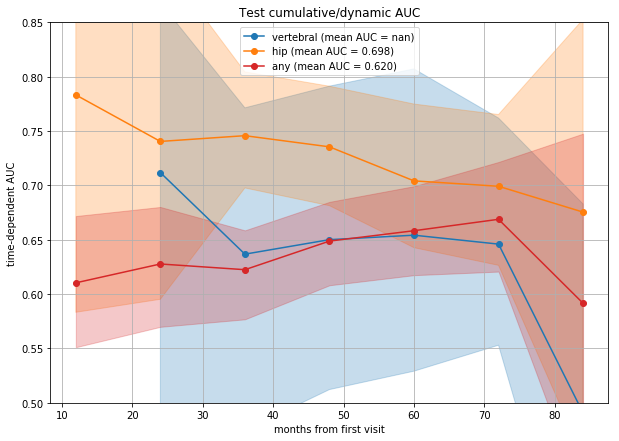

In [29]:
summary_aft = test_model(data_ukb, TIME_TO_EVALUATE, TIMES, "aft", features=FEATURES)

In [40]:
xgb_aft_test_results = {
    "vertebral": {'harrel_global': 0.6676, 'harrel_2y': 0.7203, 'uno_2y': {'c-index': 0.7124, 'lower': 0.497, 'upper': 0.868}, 'auc': 0.7118, 'auc_mean': None},
    "hip": {'harrel_global': 0.7356, 'harrel_2y': 0.7546, 'uno_2y': {'c-index': 0.7414, 'lower': 0.597, 'upper': 0.91}, 'auc': 0.7404, 'auc_mean': 0.698},
    "any": {'harrel_global': 0.6313, 'harrel_2y': 0.6237, 'uno_2y': {'c-index': 0.629, 'lower': 0.573, 'upper': 0.681}, 'auc': 0.6277, 'auc_mean': 0.6198}
}

## XGBoost Cox

vertebral


/opt/conda/lib/python3.6/site-packages/sksurv/metrics.py:460: RuntimeWarning: invalid value encountered in true_divide
  sens = numpy.array(true_pos) / ipcw[is_case].sum()
/opt/conda/lib/python3.6/site-packages/sksurv/metrics.py:460: RuntimeWarning: invalid value encountered in true_divide
  sens = numpy.array(true_pos) / ipcw[is_case].sum()



{'harrel_global': 0.69, 'harrel_2y': 0.7612, 'uno_2y': {'c-index': 0.7593, 'lower': 0.57, 'upper': 0.888}, 'auc': 0.7587, 'auc_mean': nan}

hip


/opt/conda/lib/python3.6/site-packages/sksurv/metrics.py:460: RuntimeWarning: invalid value encountered in true_divide
  sens = numpy.array(true_pos) / ipcw[is_case].sum()



{'harrel_global': 0.7872, 'harrel_2y': 0.7901, 'uno_2y': {'c-index': 0.7699, 'lower': 0.67, 'upper': 0.876}, 'auc': 0.7697, 'auc_mean': nan}

any



{'harrel_global': 0.6413, 'harrel_2y': 0.6386, 'uno_2y': {'c-index': 0.6431, 'lower': 0.582, 'upper': 0.697}, 'auc': 0.6421, 'auc_mean': 0.6381}



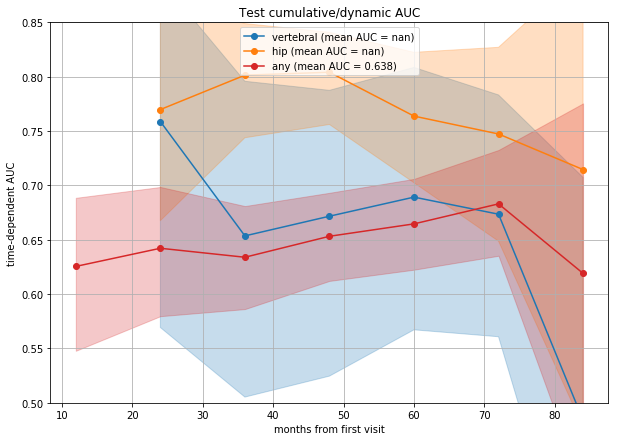

In [36]:
summary_cox = test_model(data_ukb, TIME_TO_EVALUATE, TIMES, "cox", features=FEATURES)

In [39]:
xgb_cox_test_results = {
    "vertebral": {'harrel_global': 0.69, 'harrel_2y': 0.7612, 'uno_2y': {'c-index': 0.7593, 'lower': 0.57, 'upper': 0.888}, 'auc': 0.7587, 'auc_mean': None},
    "hip": {'harrel_global': 0.7872, 'harrel_2y': 0.7901, 'uno_2y': {'c-index': 0.7699, 'lower': 0.67, 'upper': 0.876}, 'auc': 0.7697, 'auc_mean': None},
    "any": {'harrel_global': 0.6413, 'harrel_2y': 0.6386, 'uno_2y': {'c-index': 0.6431, 'lower': 0.582, 'upper': 0.697}, 'auc': 0.6421, 'auc_mean': 0.6381}
}


{'vertebral': {'harrel_global': 0.69,
  'harrel_2y': 0.7612,
  'uno_2y': {'c-index': 0.7593, 'lower': 0.57, 'upper': 0.888},
  'auc': 0.7587,
  'auc_mean': None},
 'hip': {'harrel_global': 0.7872,
  'harrel_2y': 0.7901,
  'uno_2y': {'c-index': 0.7699, 'lower': 0.67, 'upper': 0.876},
  'auc': 0.7697,
  'auc_mean': None},
 'any': {'harrel_global': 0.6413,
  'harrel_2y': 0.6386,
  'uno_2y': {'c-index': 0.6431, 'lower': 0.582, 'upper': 0.697},
  'auc': 0.6421,
  'auc_mean': 0.6381}}

In [42]:
test_results_dict = {
    "cox": cox_test_results,
    "xgb_aft": xgb_aft_test_results,
    "xgb_cox": xgb_cox_test_results,
}

df_results = pd.DataFrame()
for model_type, test_results in test_results_dict.items():
    for fx_type in test_results.keys():
        df_results.loc[fx_type, model_type] = test_results[fx_type]["uno_2y"]["c-index"]
        df_results.loc[fx_type, f"{model_type}_lower"] = test_results[fx_type]["uno_2y"]["lower"]
        df_results.loc[fx_type, f"{model_type}_upper"] = test_results[fx_type]["uno_2y"]["upper"]
df_results

,cox,cox_lower,cox_upper,xgb_aft,xgb_aft_lower,xgb_aft_upper,xgb_cox,xgb_cox_lower,xgb_cox_upper
vertebral,0.7151,0.582,0.864,0.7124,0.497,0.868,0.7593,0.570,0.888
hip,0.7516,0.607,0.901,0.7414,0.597,0.910,0.7699,0.670,0.876
any,0.5962,0.542,0.655,0.6290,0.573,0.681,0.6431,0.582,0.697


In [43]:
# Expected Shape (3 (model_type), 2 (lower+upper), 4 (fx_types))
errors = []
for model_type in ["cox", "xgb_aft", "xgb_cox"]:
    lower_and_upper = []
    for fx_type in df_results.index:
        c_index = df_results.loc[fx_type, model_type]
        lower = df_results.loc[fx_type, f"{model_type}_lower"]
        upper = df_results.loc[fx_type, f"{model_type}_upper"]
        lower_and_upper.append([c_index - lower, upper - c_index])
    errors.append(np.array(lower_and_upper).T)
errors = np.array(errors)
print(errors.shape)
errors

(3, 2, 3)


array([[[0.1331, 0.1446, 0.0542],
        [0.1489, 0.1494, 0.0588]],

       [[0.2154, 0.1444, 0.056 ],
        [0.1556, 0.1686, 0.052 ]],

       [[0.1893, 0.0999, 0.0611],
        [0.1287, 0.1061, 0.0539]]])

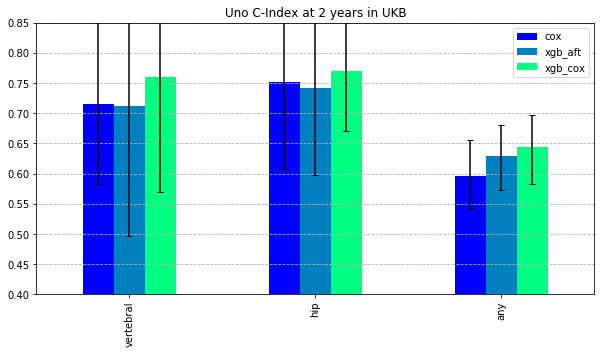

In [44]:
_, ax = plt.subplots(figsize=(10, 5))
df_results[["cox", "xgb_aft", "xgb_cox"]].plot(
    kind="bar", 
    title="Uno C-Index at 2 years in UKB", 
    ylim=(0.4, 0.85),
    yerr=errors,
    capsize=3,
    colormap="winter",
    ax=ax
)
ax.grid(axis="y", linestyle="--")

In [45]:
df_results.to_csv("results.csv")

In [ ]:
%%bash
dx upload results.